# Get data Local

In [83]:
import pandas as pd
import os
root = os.path.dirname(os.getcwd()) # get parent root dir 
heart = pd.read_csv( root + '/Data/patient_data_train.csv')

# Impute Missing Data based on Mean of Nearest Neighbors

In [84]:

# Get data within range: Same Sex, age +- 10
def getdata(sex,age,code):
    upper = age + 10
    lower = age - 10
    return heart[(heart['Sex'] == 'M') & (heart['Age'] >= lower)  & (heart['Age'] <= upper) & (heart[code] > 0)]

code = ['RestingBP', 'Cholesterol'] # two columns with empty vals

for c in code:
    
    rbp = heart[heart[c] == 0]

    for index, value in rbp.iterrows():
        df = getdata(value['Sex'], value['Age'], c)
        heart.at[index,c] = df[c].mean()

### Convert Mean val from float to int

In [85]:
heart_processed = heart
heart_processed['Cholesterol'] = heart_processed['Cholesterol'].astype(int) 
heart_processed['RestingBP'] = heart_processed['RestingBP'].astype(int)

# Density Distribution Visualization of Numeric Data(pre-modeling)
### preliminary examination of feature importance

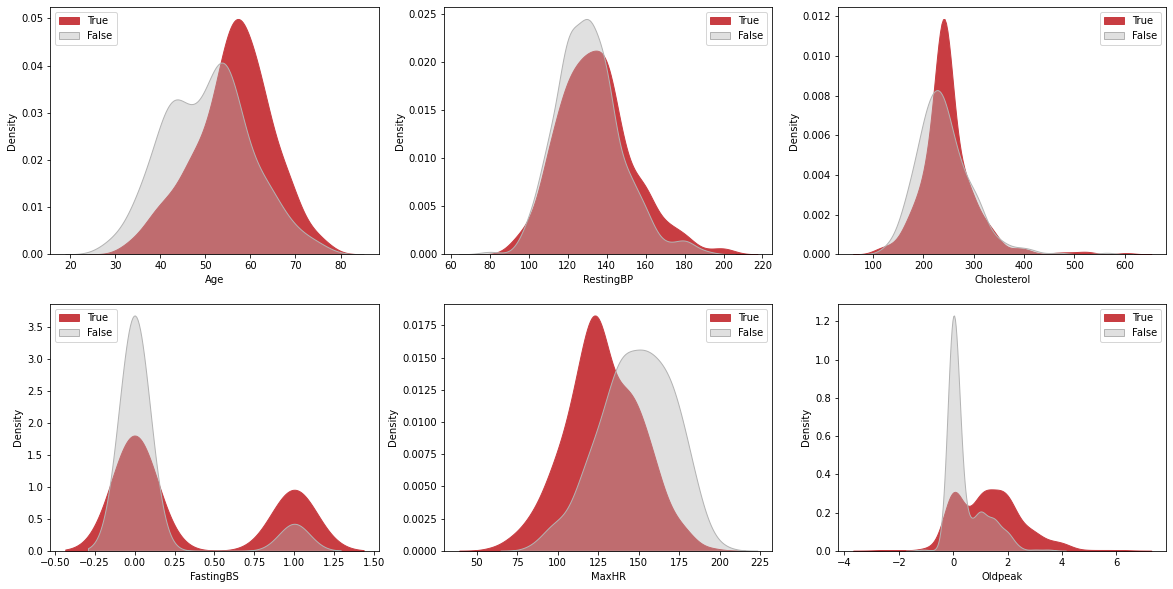

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

fig , ax = plt.subplots(ncols = 3, nrows=2 , figsize=(20,10),facecolor='white')

c1 = "#c83d42"
c2 = "#b3b3b3"

sns.kdeplot(data=heart_processed[heart_processed['HeartDisease']==1] \
            ,x='Age',ax=ax[0,0],shade=True,color=c1,alpha=1, label = 'True',legend=True)
sns.kdeplot(data=heart_processed[heart_processed['HeartDisease']==0] \
            ,x='Age',ax=ax[0,0],shade=True,color=c2,alpha=0.4, label = 'False',legend=True)

sns.kdeplot(data=heart_processed[heart_processed['HeartDisease']==1] \
            ,x='RestingBP',ax=ax[0,1],shade=True,color=c1,alpha=1, label = 'True',legend=True)
sns.kdeplot(data=heart_processed[heart_processed['HeartDisease']==0] \
            ,x='RestingBP',ax=ax[0,1],shade=True,color=c2,alpha=0.4, label = 'False',legend=True)

sns.kdeplot(data=heart_processed[heart_processed['HeartDisease']==1] \
            ,x='Cholesterol',ax=ax[0,2],shade=True,color=c1,alpha=1, label = 'True',legend=True)
sns.kdeplot(data=heart_processed[heart_processed['HeartDisease']==0] \
            ,x='Cholesterol',ax=ax[0,2],shade=True,color=c2,alpha=0.4, label = 'False',legend=True)


sns.kdeplot(data=heart_processed[heart_processed['HeartDisease']==1] \
            ,x='FastingBS',ax=ax[1,0],shade=True,color=c1,alpha=1, label = 'True',legend=True)
sns.kdeplot(data=heart_processed[heart_processed['HeartDisease']==0] \
            ,x='FastingBS',ax=ax[1,0],shade=True,color=c2,alpha=0.4, label = 'False',legend=True)

sns.kdeplot(data=heart_processed[heart_processed['HeartDisease']==1] \
            ,x='MaxHR',ax=ax[1,1],shade=True,color=c1,alpha=1, label = 'True',legend=True)
sns.kdeplot(data=heart_processed[heart_processed['HeartDisease']==0] \
            ,x='MaxHR',ax=ax[1,1],shade=True,color=c2,alpha=0.4, label = 'False',legend=True)

sns.kdeplot(data=heart_processed[heart_processed['HeartDisease']==1] \
            ,x='Oldpeak',ax=ax[1,2],shade=True,color=c1,alpha=1, label = 'True',legend=True)
sns.kdeplot(data=heart_processed[heart_processed['HeartDisease']==0] \
            ,x='Oldpeak',ax=ax[1,2],shade=True,color=c2,alpha=0.4, label = 'False',legend=True)


ax[0,0].legend(loc=2)
ax[0,1].legend()
ax[0,2].legend()
ax[1,0].legend(loc=2)
ax[1,1].legend()
ax[1,2].legend()

plt.show()

# Data Pre-processing for ML

In [105]:
# Convert to dummy for ML preparation

X = pd.get_dummies(heart_processed.drop('HeartDisease',axis=1))
y = heart_processed['HeartDisease']


In [106]:
# Balancing dataset - improves accuracy & precision

print(f"Num of heart disease data: {heart_processed[heart_processed['HeartDisease']==1].count()[0]}")
print(f"Num of non-heart disease data: {heart_processed[heart_processed['HeartDisease']==0].count()[0]}")

from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority')
X_sm, y_sm = sm.fit_resample(X, y)

print('======== After balancing Data =========')
print(f"Num of heart disease data: {y_sm[y_sm==1].count()}")
print(f"Num of non-heart disease data: {y_sm[y_sm==0].count()}")

Num of heart disease data: 387
Num of non-heart disease data: 301
======== After balancing Data =========
Num of heart disease data: 387
Num of non-heart disease data: 387


In [100]:
# Data normalization 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_sm_std = X_sm.copy() # create copy, otherwise will reflect on X_sm
X_sm_std[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']] = scaler.fit_transform(X_sm_std[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']])

## Determining Optimum Model (K-fold validation)

In [15]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC

def model_comparison(x,y):
    all_model = [LogisticRegression(max_iter=10000), KNeighborsClassifier(), DecisionTreeClassifier(random_state = 41), RandomForestClassifier(random_state = 41), BernoulliNB(), GaussianNB(), SVC()]
    
    
    recall = []
    precision = []
    f1=[]
    accuracy = []
    roc = []
    
    for model in all_model:
        
        c = 5 # small dataset
        cv = cross_val_score(model, x, y, scoring='accuracy', cv=c, n_jobs = -1).mean()
        accuracy.append(format(cv,".4f"))

        cv = cross_val_score(model, x, y, scoring='recall', cv=c, n_jobs = -1).mean()
        recall.append(format(cv,".4f"))

        cv = cross_val_score(model, x, y, scoring='precision', cv=c, n_jobs = -1).mean()
        precision.append(format(cv,".4f"))

        cv = cross_val_score(model, x, y, scoring='roc_auc', cv=c, n_jobs = -1).mean()
        roc.append(format(cv,".4f"))
    

    model = ['LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier','RandomForestClassifier', 'BernoulliNB', 'GaussianNB', 'SVC']

    score = pd.DataFrame({'Model': model, 'Accuracy' : accuracy, 'Precision': precision, 'Recall': recall,  'ROC': roc})
    
    return score

# Compare Performance via Standardizing

#### KNeighbors & SVC showed substantial improvement, RandomForest is unaffected

In [107]:
frame = model_comparison(X_sm_std,y_sm)
display(frame)
### SVC shows the highest average scores, thus the group decided to use SVC

### Repeated attempts may show RF having higher scores
### Model implementation on test dataset yields higher scores for SVC

,Model,Accuracy,Precision,Recall,ROC
0,LogisticRegression,0.8644,0.8650,0.8680,0.9321
1,KNeighborsClassifier,0.8631,0.8495,0.8862,0.9118
2,DecisionTreeClassifier,0.7959,0.7960,0.7983,0.7959
3,RandomForestClassifier,0.8799,0.8652,0.9016,0.9315
4,BernoulliNB,0.8631,0.8673,0.8604,0.9274
5,GaussianNB,0.8605,0.8573,0.8681,0.9141
6,SVC,0.8709,0.8533,0.9017,0.9280


## Fine tuning SVC - GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1,0.5, 1, 5,10], 'gamma': [1,0.1,0.05, 0.06, 0.07, 0.08, 0.09, 0.01,0.005,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

gs = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)

gs.fit(X_sm_std,y_sm)

print(gs.best_estimator_)

## Evaluating Models based on Test data

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef

def modeleval(X_train,x_test,y_train,y_test):
    all_model = [SVC(),SVC(C=10, gamma=0.05, kernel='poly')]
    
    model2 =  ['SVC_base', 'SVC_tuned']
    count = 0
    
    ret = []
    ret2 = []
    for model in all_model:
          
        rf = model
        rf.fit(X_train,y_train)

        y_predicted = rf.predict(x_test)
        # Confusion Matrix

        c_m = confusion_matrix(y_test,y_predicted)
        result = {}
        result2 = {}
        print(f"\n==========={model2[count]}============")
        print(f'Confusion Matrix:\n\n {c_m}\n')
          
        TP = c_m[0,0]
        FP = c_m[0,1]
        FN = c_m[1,0]
        TN = c_m[1,1]
        result['model'] = model2[count]
        result['True Positive'] = TP
        result['False Positive'] = FP
        result['False Negative'] = FN
        result['True Negative'] = TN
        result2['model'] = model2[count]
        result2['Accuracy'] = (TP + TN) / (TP + TN + FP + FN)
        result2['Precision'] = TP / (TP + FP)
        #result2['Misclassification'] = (FP + FN) / (TP + TN + FP + FN)
        result2['Specificity'] = TN / (TN + FP)
        result2['Sensitivity'] = TP / (TP + FN)
        result2['MattCorr'] = matthews_corrcoef(y_test,y_predicted)
        # Matthews Corr
        count +=1
        ret.append(result)
        ret2.append(result2)
        
    return ret,ret2

In [50]:
# import test data

df = pd.read_csv(root +"/Data/patient_data_test_raw.csv")
X_test = pd.get_dummies(df.drop('HeartDisease', axis = 1 ))
y_test = df['HeartDisease']

scaler = StandardScaler()
X_test_std = X_test.copy() # create copy
X_test_std[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']] = scaler.fit_transform(X_test_std[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']])
list2 = ["RestingECG_ST"\
         ,"ST_Slope_Down"\
         , "ChestPainType_TA"\
         , "ChestPainType_ATA"\
         , "Cholesterol"\
         , "ChestPainType_NAP"]

X_sm_std2 = X_sm_std.drop(list2,axis=1)
X_test_std2 = X_test_std.drop(list2,axis=1)

cf, score = modeleval(X_sm_std, X_test_std, y_sm, y_test)
cf2, score2 = modeleval(X_sm_std2, X_test_std2, y_sm, y_test)


===========SVC_base============
Confusion Matrix:

 [[ 90  19]
 [ 11 110]]


===========SVC_tuned============
Confusion Matrix:

 [[ 94  15]
 [ 17 104]]


===========SVC_base============
Confusion Matrix:

 [[ 93  16]
 [ 11 110]]


===========SVC_tuned============
Confusion Matrix:

 [[ 97  12]
 [ 20 101]]



In [4]:
display(pd.DataFrame(score))

NameError: name 'score' is not defined

In [52]:
display(pd.DataFrame(score2))

[{'model': 'SVC_base',
  'Accuracy': 0.8826086956521739,
  'Precision': 0.8532110091743119,
  'Specificity': 0.873015873015873,
  'Sensitivity': 0.8942307692307693,
  'MattCorr': 0.7647702839200574},
 {'model': 'SVC_tuned',
  'Accuracy': 0.8608695652173913,
  'Precision': 0.8899082568807339,
  'Specificity': 0.8938053097345132,
  'Sensitivity': 0.8290598290598291,
  'MattCorr': 0.7237415384661096}]

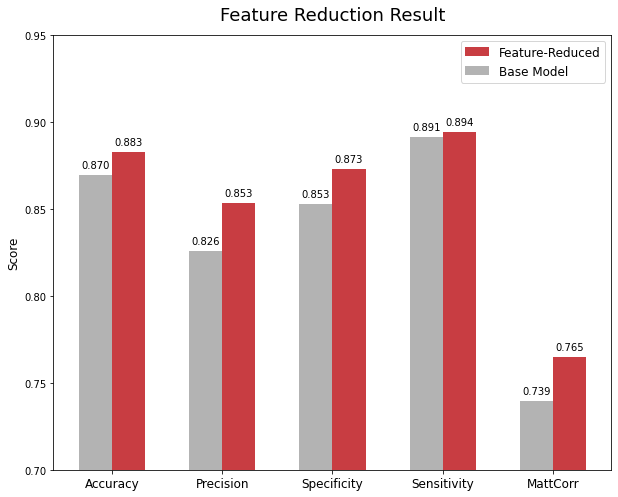

In [82]:
import matplotlib.pyplot as plt
import numpy as np


# Initialise a figure. subplots() with no args gives one plot.
fig, ax = plt.subplots(figsize = (10,8))

temp = pd.DataFrame({"Base":list(score[0].values())[1:],'Reduced':list(score2[0].values())[1:]})

pd.DataFrame(temp)
x = ['Accuracy','Precision','Specificity','Sensitivity','MattCorr']
width = 0.3
# A little data preparation
# Plot each bar plot. Note: manually calculating the 'dodges' of the bars
a = ax.bar(np.arange(len(x))+width/2, temp['Reduced'], width, label='Feature-Reduced', color='#c83d42')
b = ax.bar(np.arange(len(x))-width/2, temp['Base'], width, label='Base Model', color='#b3b3b3')

#ax.set_facecolor("white")
#ax.patch.set_edgecolor('black')  
#ax.patch.set_linewidth('2')
ax.set_ylabel('Score',fontsize=12)
ax.set_title('Feature Reduction Result', fontsize=18, y = 1.02)
ax.set_xticks(np.arange(len(x)))    # This ensures we have one tick per year, otherwise we get fewer
ax.set_xticklabels(x,fontsize=12)
ax.set_ylim([0.7, 0.95])
ax.legend(fontsize=12)
#ax.bar_label(a,padding=4)
#ax.bar_label(b,padding=4)
# Ask Matplotlib to show the plot

for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


In [0]:
# SVC is suitable for binary classification problems with small dataset
# Tuned SVC shows a slight decrease across all scoring metrics
# Tuned SVC do have 2 more cases of TP, but is outweighted by 5 more cases of FN, which is the worst case in disease diagnosis.
# Considering the above two factors the model is left untuned.

# Feature Importance (may not be accurate for rbf)

[ 2  9 17 10 14 11 12 13  0 15  6 16 19  4  7  1  3  8  5 18]


Text(0.5, 0, 'Permutation Importance')

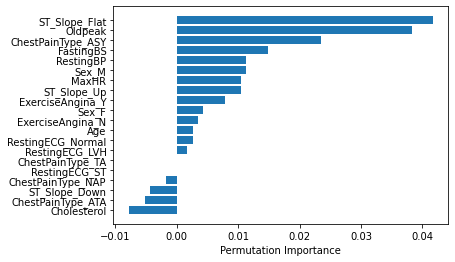

In [64]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

svc =  SVC()
svc.fit(X_sm_std, y_sm)

perm_importance = permutation_importance(svc, X_test_std, y_test)
feature_names = []
for x in range(20):  
    feature_names.append(X_sm_std.columns[x])
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()

print(perm_importance.importances_mean.argsort())

plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")


In [1]:
import sklearn
import numpy
import matplotlib as plt
import imblearn
import seaborn
import pandas

print(f"sklearn: {sklearn.__version__}")
print(f"numpy: {numpy.__version__}")
print(f"matplotlib: {plt.__version__}")
print(f"imblearn: {imblearn.__version__}")
print(f"seaborn: {seaborn.__version__}")
print(f"pandas: {pandas.__version__}")

sklearn: 0.24.2
numpy: 1.20.3
matplotlib: 3.5.0
imblearn: 0.7.0
seaborn: 0.11.2
pandas: 1.3.4
